## DAQ and Data cleaning CustomerDemographic

In [18]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import date
import math

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
cust_demo = pd.read_excel('Raw_data.xlsx', sheet_name='CustomerDemographic')
cust_demo.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [3]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

* So from the info we can see that `last_name` and `default` can be dropped from the dataset.

### 1. Dropping not relevant variables

In [4]:
cust_demo.drop(['last_name','default'],axis=1,inplace=True)
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   gender                               4000 non-null   object        
 3   past_3_years_bike_related_purchases  4000 non-null   int64         
 4   DOB                                  3913 non-null   datetime64[ns]
 5   job_title                            3494 non-null   object        
 6   job_industry_category                3344 non-null   object        
 7   wealth_segment                       4000 non-null   object        
 8   deceased_indicator                   4000 non-null   object        
 9   owns_car                             4000 non-null   object        
 10  tenure      

### 2. Checking  and handling missing values

In [5]:
cust_demo.isnull().sum()

customer_id                              0
first_name                               0
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                  87
dtype: int64

In [6]:
# custom function to impute missing values

def impute_nan(df, variable):
    """taking sample from non null values"""
    random_sample = df[variable].dropna().sample(df[variable].isnull().sum(),random_state=42)
    """taking index of missing values"""
    random_sample.index = df[df[variable].isnull()].index
    """imputing the missing values using random sample"""
    df.loc[df[variable].isnull(),variable] = random_sample

In [7]:
for i in ['DOB','job_title','job_industry_category','tenure']:
    impute_nan(cust_demo,i)
    
cust_demo.isnull().sum()

customer_id                            0
first_name                             0
gender                                 0
past_3_years_bike_related_purchases    0
DOB                                    0
job_title                              0
job_industry_category                  0
wealth_segment                         0
deceased_indicator                     0
owns_car                               0
tenure                                 0
dtype: int64

* The missing values has been imputed using **Random Sample Imputation**

### 3. Feature Engineering

In [8]:
# custom function to create age

def age(born):
    today = date.today()
    
    age = today.year - born.year - ((today.month, today.day) > (born.month, born.day))
    
    return age

cust_demo['Age'] = cust_demo['DOB'].apply(age)

In [9]:
cust_demo['Age'].describe()

count    4000.000000
mean       46.344000
std        12.831614
min        21.000000
25%        37.000000
50%        46.000000
75%        56.000000
max       181.000000
Name: Age, dtype: float64

* The max value of age is 181, which is highly unlikely to happen so it has to be an outlier, since mean is 46 only.

* creating another group called age_group.

In [19]:
cust_demo['Age_group'] = cust_demo['Age'].apply(lambda x: (math.floor(x/10)+1)*10)

<AxesSubplot:xlabel='Age_group', ylabel='count'>

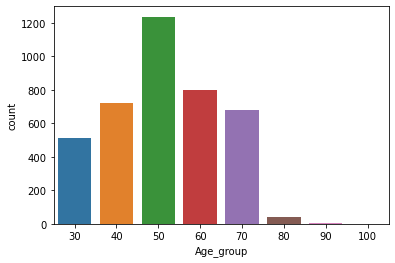

In [20]:
sns.countplot(cust_demo['Age_group'])

### 4. checking for outliers

<AxesSubplot:xlabel='Age'>

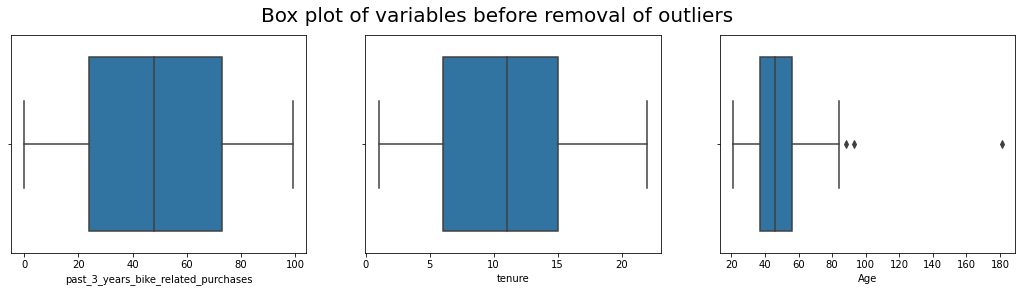

In [10]:
plt.figure(figsize=(18,4))
plt.suptitle("Box plot of variables before removal of outliers",fontsize=20)

plt.subplot(1,3,1)
sns.boxplot(cust_demo['past_3_years_bike_related_purchases'])

plt.subplot(1,3,2)
sns.boxplot(cust_demo['tenure'])

plt.subplot(1,3,3)
sns.boxplot(cust_demo['Age'])

* clearly there are a few outliers in age column which has to dealth with.
* outliers can be removed using various methods like `IQR`, but here for we can simply remove entries which are greater than 100.

In [11]:
# dropping outliers from age column using index

age_index = cust_demo[cust_demo['Age'] > 100].index
cust_demo.drop(index=age_index,inplace=True,axis=0)

cust_demo['Age'].describe()

count    3999.000000
mean       46.310328
std        12.655238
min        21.000000
25%        37.000000
50%        46.000000
75%        56.000000
max        93.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age'>

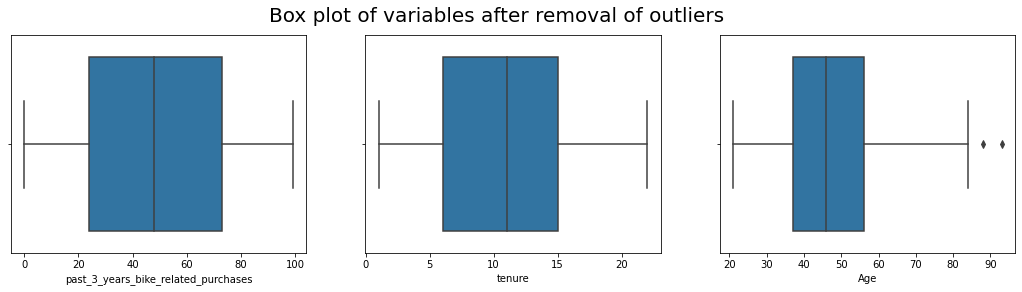

In [12]:
plt.figure(figsize=(18,4))
plt.suptitle("Box plot of variables after removal of outliers",fontsize=20)

plt.subplot(1,3,1)
sns.boxplot(cust_demo['past_3_years_bike_related_purchases'])

plt.subplot(1,3,2)
sns.boxplot(cust_demo['tenure'])

plt.subplot(1,3,3)
sns.boxplot(cust_demo['Age'])

* The affected rows are dropping the outliers is only 1.

### 5. Checking for inconsistency in dataset

In [13]:
for i in ['gender','job_industry_category','wealth_segment','deceased_indicator','owns_car']:
    print(i)
    print(cust_demo[i].value_counts(),"\n\n")

gender
Female    2037
Male      1872
U           87
F            1
Femal        1
M            1
Name: gender, dtype: int64 


job_industry_category
Manufacturing         950
Financial Services    933
Health                713
Retail                435
Property              330
IT                    265
Entertainment         163
Argiculture           133
Telecommunications     77
Name: job_industry_category, dtype: int64 


wealth_segment
Mass Customer        2000
High Net Worth       1021
Affluent Customer     978
Name: wealth_segment, dtype: int64 


deceased_indicator
N    3997
Y       2
Name: deceased_indicator, dtype: int64 


owns_car
Yes    2024
No     1975
Name: owns_car, dtype: int64 




* `Gender` column has some inconsistency, so **U** canbe replaced with "unidentified", **F** with "Female", **Femal** with "Female", **M** with "Male".

In [14]:
# custom function to steamline the gender column

def replace_gender_names(gender):
    
    if gender=='U':
        return "Unidentified"
    elif gender=='F':
        return "Female"
    elif gender=='Femal':
        return "Female"
    elif gender=='M':
        return "Male"
    else:
        return gender

cust_demo['gender'] = cust_demo['gender'].apply(replace_gender_names)

In [15]:
cust_demo['gender'].value_counts()

Female          2039
Male            1873
Unidentified      87
Name: gender, dtype: int64

### 6. Checking for duplicates

In [21]:
cust_demo[cust_demo.duplicated()==True]

,customer_id,first_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age,Age_group


* There are no duplicates in the dataset.
* so saving the cleaned dataset as csv format for further analysis.

In [22]:
cust_demo.to_csv('CustomerDemographic.csv',index=False)